In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

---
# Step 1: Gather data, determine the method of data collection and provenance of the data (1 point)
> In the earliest phase, select a data source and problem. Feel free to share and discuss your idea on the class discussion board.

**Author:** Elizabeth Martin <br>
**Github:** [final-sentiment-analysis-movie-reviews](https://github.com/Elizabeth-Martin2/machine-learning/tree/main/deep-learning) <br>

**Data Source:** This is a kaggle competition with a dataset consisting of positive & negative movie reviews from IMDB.  This dataset was collected in association with the following publication: Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). "Learning Word Vectors for Sentiment Analysis." The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011). <br>
**References:** See the [references section](#References:) for more details on research, modules, & reference notebooks.

---
# Step 2: Identify a Deep Learning Problem (5 points)
> If you're going to use a Kaggle competition or similar, you must focus more on model building and/or analysis to be a valid project. Replicating what's in the Kaggle kernel or other notebooks available online is not a valid project. It is reasonable to add different approaches and compare them with the Kaggle kernel or other notebooks available online. It is also good to find a research paper, implement an algorithm, and run experiments comparing its performance to different algorithms.

My first focus will be implementing Google's Word2Vec method to generate word vectors to then feed into a recurrent neural network and determine the sentiment of the movie reiew.  I will then analyize differnet network architectures and fine-tune the hyperparameters to optimize the performance.<br>

---
# Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data (34 points)
> Go through the initial data cleaning and EDA and judge whether you need to collect more or different data. 



In [42]:
# Read data from files 
train = pd.read_csv('/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip', header=0, delimiter="\t", quoting=3 )
test = pd.read_csv( "/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip", header=0, delimiter="\t", quoting=3 )

eda_train_copy = train.copy()
eda_test_copy = test.copy()

u_train = pd.read_csv( "/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip", header=0, delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print ("Read %d labeled train reviews, %d labeled test reviews, and %d unlabeled reviews\n" % (train["review"].size, test["review"].size, u_train["review"].size))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



## Inspecting the dataset

In [43]:
print(f"The training dataset has shape: {train.shape}, with columns: {train.columns}")
print(f"The testing dataset has shape: {test.shape}, with columns: {test.columns}")
print()
print(f"Sample review (with a sentiment rating of {train['sentiment'][0]}): {train['review'][0]}")

The training dataset has shape: (25000, 3), with columns: Index(['id', 'sentiment', 'review'], dtype='object')
The testing dataset has shape: (25000, 2), with columns: Index(['id', 'review'], dtype='object')

Sample review (with a sentiment rating of 1): "With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate thi

In [5]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


## Visualizing & metadata

In [44]:
# Modules for EDA & word analysis
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) 

import string

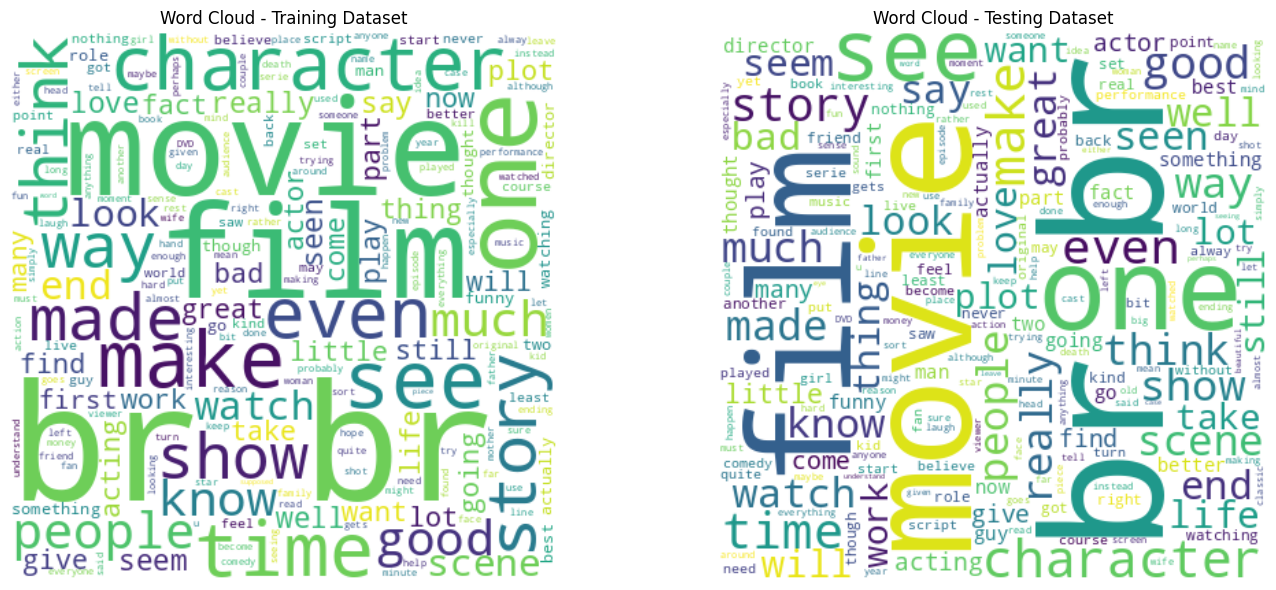

In [45]:
# Concatenate review columns 
all_train_reviews = ' '.join(eda_train_copy['review']) + ' ' + ' '.join(u_train['review'])
all_test_reviews = ' '.join(eda_test_copy['review'])

# Generate wordclouds
wordcloud_train = WordCloud(width=400, height=400, background_color='white').generate(all_train_reviews)
wordcloud_test = WordCloud(width=400, height=400, background_color='white').generate(all_test_reviews)

# Plot them side by side for comparison
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_train, interpolation='bilinear')
plt.title('Word Cloud - Training Dataset')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_test, interpolation='bilinear')
plt.title('Word Cloud - Testing Dataset')
plt.axis('off')

plt.tight_layout()
plt.show()


At a first glance, we can see some of the markdown is coming out as the most common words ('br' is used to put breaks between lines) in both datasets.  This probably doesn't give us any useful information, so it would be good to remove it during the datacleaning.

In [46]:
# Total word count
eda_train_copy['word_count'] = eda_train_copy['review'].apply(lambda x: len(x.split()))
eda_test_copy['word_count'] = eda_test_copy['review'].apply(lambda x: len(x.split()))

# Unique word count
eda_train_copy['uni_word_count'] = eda_train_copy['review'].apply(lambda x: len(set(x.split())))
eda_test_copy['uni_word_count'] = eda_test_copy['review'].apply(lambda x: len(set(x.split())))

# Stop word count
eda_train_copy['stop_word_count'] = eda_train_copy['review'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))
eda_test_copy['stop_word_count'] = eda_test_copy['review'].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]))

# Character count
eda_train_copy['char_count'] = eda_train_copy['review'].apply(lambda x: len(str(x)))
eda_test_copy['char_count'] = eda_test_copy['review'].apply(lambda x: len(str(x)))

# Punctuation count
eda_train_copy['punct_count'] = eda_train_copy['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
eda_test_copy['punct_count'] = eda_test_copy['review'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

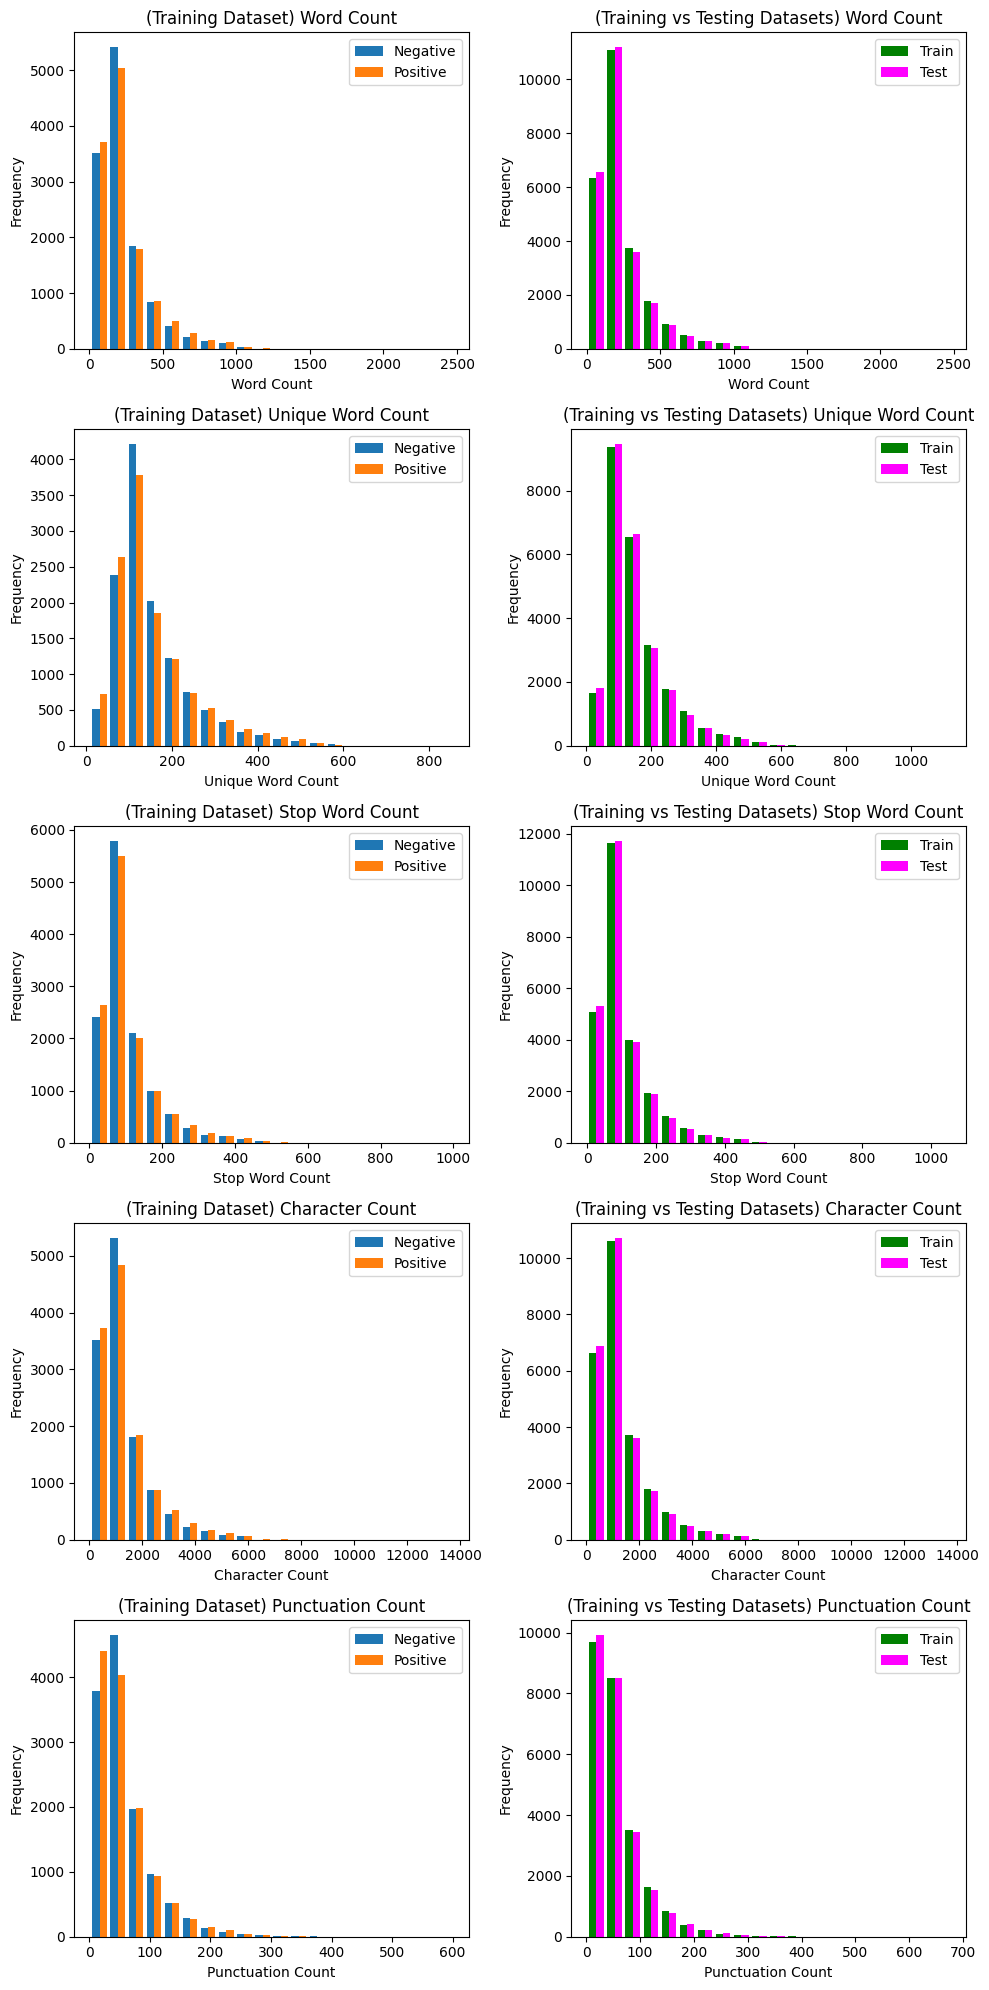

In [47]:
# Sentiment 0 = negative ; 1 = positive
negative_reviews = eda_train_copy['sentiment'] == 0
fig, axes = plt.subplots(ncols = 2, nrows = 5, figsize = (10, 20))

# Total word count
axes[0, 0].hist([eda_train_copy.loc[negative_reviews]['word_count'], eda_train_copy.loc[~negative_reviews]['word_count']], bins=20, label=['Negative', 'Positive'])
axes[0, 0].set_title('(Training Dataset) Word Count')
axes[0, 0].legend()
axes[0, 0].set_xlabel('Word Count')
axes[0, 0].set_ylabel('Frequency')

# Unique word count
axes[1, 0].hist([eda_train_copy.loc[negative_reviews]['uni_word_count'], eda_train_copy.loc[~negative_reviews]['uni_word_count']], bins=20, label=['Negative', 'Positive'])
axes[1, 0].set_title('(Training Dataset) Unique Word Count')
axes[1, 0].legend()
axes[1, 0].set_xlabel('Unique Word Count')
axes[1, 0].set_ylabel('Frequency')

# Stop word count
axes[2, 0].hist([eda_train_copy.loc[negative_reviews]['stop_word_count'], eda_train_copy.loc[~negative_reviews]['stop_word_count']], bins=20, label=['Negative', 'Positive'])
axes[2, 0].set_title('(Training Dataset) Stop Word Count')
axes[2, 0].legend()
axes[2, 0].set_xlabel('Stop Word Count')
axes[2, 0].set_ylabel('Frequency')

# Character count
axes[3, 0].hist([eda_train_copy.loc[negative_reviews]['char_count'], eda_train_copy.loc[~negative_reviews]['char_count']], bins=20, label=['Negative', 'Positive'])
axes[3, 0].set_title('(Training Dataset) Character Count')
axes[3, 0].legend()
axes[3, 0].set_xlabel('Character Count')
axes[3, 0].set_ylabel('Frequency')

# Punctuation count
axes[4, 0].hist([eda_train_copy.loc[negative_reviews]['punct_count'], eda_train_copy.loc[~negative_reviews]['punct_count']], bins=20, label=['Negative', 'Positive'])
axes[4, 0].set_title('(Training Dataset) Punctuation Count')
axes[4, 0].legend()
axes[4, 0].set_xlabel('Punctuation Count')
axes[4, 0].set_ylabel('Frequency')

# ------ Compare training w/testing ------ #

# Total word count
axes[0, 1].hist([eda_train_copy['word_count'], eda_test_copy['word_count']], bins=20, label=['Train', 'Test'], color=['green', 'magenta'])
axes[0, 1].set_title('(Training vs Testing Datasets) Word Count')
axes[0, 1].legend()
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')

# Unique word count
axes[1, 1].hist([eda_train_copy['uni_word_count'], eda_test_copy['uni_word_count']], bins=20, label=['Train', 'Test'], color=['green', 'magenta'])
axes[1, 1].set_title('(Training vs Testing Datasets) Unique Word Count')
axes[1, 1].legend()
axes[1, 1].set_xlabel('Unique Word Count')
axes[1, 1].set_ylabel('Frequency')

# Stop word count
axes[2, 1].hist([eda_train_copy['stop_word_count'], eda_test_copy['stop_word_count']], bins=20, label=['Train', 'Test'], color=['green', 'magenta'])
axes[2, 1].set_title('(Training vs Testing Datasets) Stop Word Count')
axes[2, 1].legend()
axes[2, 1].set_xlabel('Stop Word Count')
axes[2, 1].set_ylabel('Frequency')

# Character count
axes[3, 1].hist([eda_train_copy['char_count'], eda_test_copy['char_count']], bins=20, label=['Train', 'Test'], color=['green', 'magenta'])
axes[3, 1].set_title('(Training vs Testing Datasets) Character Count')
axes[3, 1].legend()
axes[3, 1].set_xlabel('Character Count')
axes[3, 1].set_ylabel('Frequency')

# Punctuation count
axes[4, 1].hist([eda_train_copy['punct_count'], eda_test_copy['punct_count']], bins=20, label=['Train', 'Test'], color=['green', 'magenta'])
axes[4, 1].set_title('(Training vs Testing Datasets) Punctuation Count')
axes[4, 1].legend()
axes[4, 1].set_xlabel('Punctuation Count')
axes[4, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Analysis
The left column is a comparison of the negative to positive sentiment reviews in the training dataset.  Similar to the sample from the inspection section above, the majority of reviews are around 250 words.  In this bucket, the negative reviews tend to be longer, which can be explained as negative people tend to rant more.  In the most frequent bucket, the negative counts tend to pull ahead, with more unique & stop words, and character & punctuation counts.  But the other buckets are generally well matched.  

The right column is a comparison of the training dataset (with both positive & negative reviews mixed together) to the testing dataset.  We can see that they are pretty well matched in every aspect. 

## Cleaning

Based on the above analysis, we can remove the markdown words, any punctuation or numbers, and we'll convert words to lowercase.  I've decided to leave in the stop words and contractions, as the Word2Vec model is supposed to analyze the broader context of the sentence.  I'll start with this configuration and if it performs poorly I can return here and clean it a bit more.  

I'm going to use the Beautiful soup library which is most commonly used for webscraping making it ideal for parsing the reviews & removing the markdown symbols.  The Word2Vec model also expects an input of individual sentences, so I'll make that adjustment as well.

In [48]:
from spacy import load
import nltk.data
nltk.download('wordnet')
nltk.download('wordnet2022')
nlp = load('en_core_web_sm')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.

import re
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!


In [49]:
from bs4 import BeautifulSoup

def review_to_clean_words(review):
    review = BeautifulSoup(review).get_text() # Remove the HTML / markdown tags e.g., </ br>
    review = re.sub("[^a-zA-Z]", " ", review) # Remove non-character letters
    words = review.lower().split()            # Convert to lowercase & split review to individual words
    return words

def reviews_to_clean_sentences(review, tokenizer):
    tok_sentences = tokenizer.tokenize(review.strip()) # Remove whitespace
    cleaned_sentences = []
    
    for tok_sentence in tok_sentences:
        if len(tok_sentence) > 0:
            cleaned_sentences.append(review_to_clean_words(tok_sentence))
    
    return cleaned_sentences


train_sentences = []
for review in train['review']: 
    train_sentences += reviews_to_clean_sentences(review, tokenizer)

for review in u_train['review']:
    train_sentences += reviews_to_clean_sentences(review, tokenizer)

/tmp/ipykernel_34/210910074.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review).get_text() # Remove the HTML / markdown tags e.g., </ br>
/tmp/ipykernel_34/210910074.py:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  review = BeautifulSoup(review).get_text() # Remove the HTML / markdown tags e.g., </ br>


In [50]:
print("Let's take another look at the first review so we can see how the cleaning has performed:\n")
sample = [word for sentence in train_sentences[0:15] for word in sentence]
print(f"{' '.join(sample)}")
print()
print("We can see that the sample we previously looked at has now been divided into 15 sentences, the markdown tags have been revmoed, as well as punctuation.  Everything is lowercase, and the contractions are split.")

Let's take another look at the first review so we can see how the cleaning has performed:

with all this stuff going down at the moment with mj i ve started listening to his music watching the odd documentary here and there watched the wiz and watched moonwalker again maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent moonwalker is part biography part feature film which i remember going to see at the cinema when it was originally released some of it has subtle messages about mj s feeling towards the press and also the obvious message of drugs are bad m kay visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring some may call mj an egotist for consenting to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really 

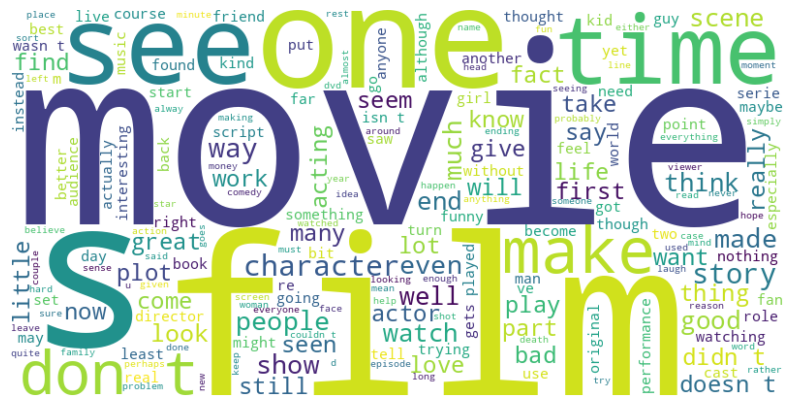

In [51]:
# Let's join the words back together to make another wordcloud
all_cleaned_words = [word for sentence in train_sentences for word in sentence]
all_cleaned_text = ' '.join(all_cleaned_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_cleaned_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


It looks much better! There's no markdown and the largest words are ones that we would expect to see - film & movies.  The cleaning has performed well.  Let's move on to the actual model!

---
# Step 4: Perform Analysis Using Deep Learning Models of your Choice, Present Discussion, and Conclusions (65 points)
> Start the main analysis (the main analysis refers to supervised learning tasks such as classification or regression).

The first step in  my model creation will be the word2vec model creation.  The majority of the cleaning and prep I have done so far has been for this model, but that is only in preparation for my neural network afterwards.  The word2vec model will provide several benefits to my neural network afterwards such as: 
- Word embeddings: The word2vec model will have pre-trained word embeddings that have additional information about the words, their meaning, and relationship with other words.  My NN will be able to leverage this information during training
- Semantic similarity: The embeddings encode semantic similarity between words, which will allow my NN to generalize better to words it hasn't seen before but are *semantically* similar to words it saw during the training
- Dimensionality reduction: With the cleaning and the word embedding, we will have reduced the dimensionality which will help avoid overfitting in my NN model training
- Transfer learning: The pre-trained word embeddings and the captured semantic similarity will also allow my NN to benefit from transfer learning

## Word2Vec Model creation

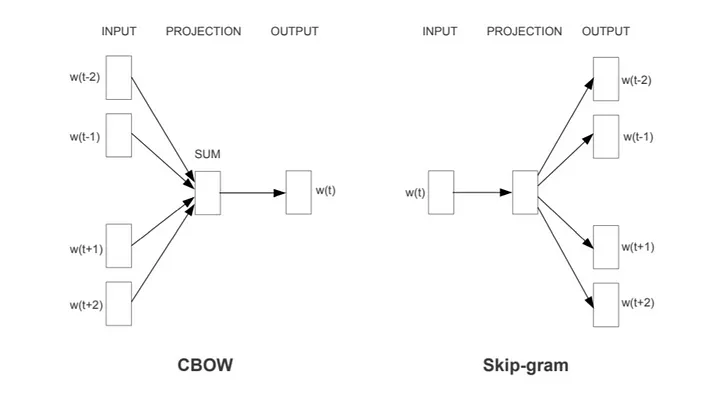 <br>
Source: Exploiting Similarities among Languages for Machine Translation paper \[[3.A](#References:)\].

For my model I will use the skip-gram algorithm. This algorithm predicts the surrounding words given the target word within a context window.  It uses a neural network architecture, with a single input node representing the target word, and several output nodes representing the surrounding words.

The CBOW algorithm works in the opposite direction, predicting a target word based on the context surrounding it.  Again, it mimics a neural netword with several input nodes respresenting the words around the target word and a single output node representing the target word.

In [138]:
from gensim.models import word2vec
training_min = eda_train_copy['word_count'].min()
testing_min = eda_test_copy['word_count'].min()

print(f"From the EDA we saw that the min word counts were {training_min} in the training dataset, and {testing_min} in the testing dataset.")
model = word2vec.Word2Vec(train_sentences, workers = 4, min_count = 4, window = 10, sample = .001)
model.init_sims(replace=True)
model.save("word2vec")

From the EDA we saw that the min word counts were 10 in the training dataset, and 4 in the testing dataset.


/tmp/ipykernel_34/1523398212.py:7: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


Now that the model has been created, we can see how it works!  In the below cells, you can see that it is able to pick out the word that doesn't match with the others.  It can also give us similar words to one we provide, generate anaologies, and output a similarity score of two words.

In [136]:
mismatch1 = model.wv.doesnt_match("dog cat bird car".split())
print(f"In the collection: \"dog cat bird car\" the word out of place is: {mismatch1}")

mismatch2 = model.wv.doesnt_match("louisiana georgia california houston".split())
print(f"\nIn the collection: \"louisiana georgia california houston\" the word out of place is: {mismatch2}")

similar_words = model.wv.most_similar("dog")
print(f"\nSimilar words to dog: {similar_words}")

analogy = model.wv.most_similar(positive=['king', 'woman'], negative=['man'])
print(f"\nGenerated analogy for king & woman: {analogy}")

dc_similarity = model.wv.similarity("dog", "cat")
ip_similarity = model.wv.similarity("insect", "person")
print(f"\nSimilarity between dog & cat: {dc_similarity}, and between insect & person: {ip_similarity}")

In the collection: "dog cat bird car" the word out of place is: car

In the collection: "louisiana georgia california houston" the word out of place is: houston

Similar words to dog: [('cat', 0.7651888132095337), ('chicken', 0.7186778783798218), ('puppy', 0.6951766610145569), ('bird', 0.6878423094749451), ('pet', 0.6797910928726196), ('horse', 0.6442170143127441), ('robot', 0.6399447917938232), ('grandma', 0.6287732720375061), ('rat', 0.62800133228302), ('monkey', 0.6264901161193848)]

Generated analogy for king & woman: [('queen', 0.6707890629768372), ('princess', 0.6287147998809814), ('prince', 0.6189829707145691), ('bride', 0.5865336060523987), ('countess', 0.5546588897705078), ('juliet', 0.5516339540481567), ('mary', 0.5356326103210449), ('temple', 0.5221445560455322), ('stepmother', 0.5136469602584839), ('ursula', 0.5097699761390686)]

Similarity between dog & cat: 0.7651888132095337, and between insect & person: 0.15509939193725586


## Neural Network model creation
I will be creating a long short-term memory recurrent neural network.  The structure will be as follows:
1. My first layer will be an embedding layer, this is essential for utilizing the pre-trained word embeddings from my word2vec model.  
2. Then a long short term memory layer.  This layer worked well for me in a previous competition (disaster tweets) and is known to perform well in language processing tasks because of its ability to process varying lengths of sequences while still retaining its memory
3. The final layer will be a dense layer with a softmax activation function.  Softmax is best to ensure that the output probabilities sum to 1 

For the compilation of the model I'll first try categorical cross-entropy loss with the Adam optimizer.  The Adam optimizer is an adaptive learning rate optimization algorithm, so it should perform well and converge quickly.

In [139]:
# Rewriting cleaning functions for NN training - don't split every word
def review_to_clean_words(review):
    review = BeautifulSoup(review, "html.parser").get_text() # Remove the HTML / markdown tags e.g., </ br>
    review = re.sub("[^a-zA-Z]", " ", review) # Remove non-character letters
    review = review.lower()                  # Convert to lowercase
    words = review.split()                   # Split review to individual words
    return words

def reviews_to_clean_sentences(reviews):
    cleaned_sentences = []
    
    for review in reviews:
        cleaned_review = review_to_clean_words(review)
        cleaned_sentences.append(cleaned_review)
    
    return cleaned_sentences

cleaned_reviews_train = reviews_to_clean_sentences(train['review'])

/tmp/ipykernel_34/3677764332.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, "html.parser").get_text() # Remove the HTML / markdown tags e.g., </ br>


In [140]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [141]:
labels = train['sentiment'].tolist()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(cleaned_reviews_train, labels, test_size=0.2, random_state=42)

# Convert text data into sequences of word indices
X_train_seq = [[model.wv.key_to_index[word] for word in sentence if word in model.wv.key_to_index] for sentence in X_train]
X_test_seq = [[model.wv.key_to_index[word] for word in sentence if word in model.wv.key_to_index] for sentence in X_test]

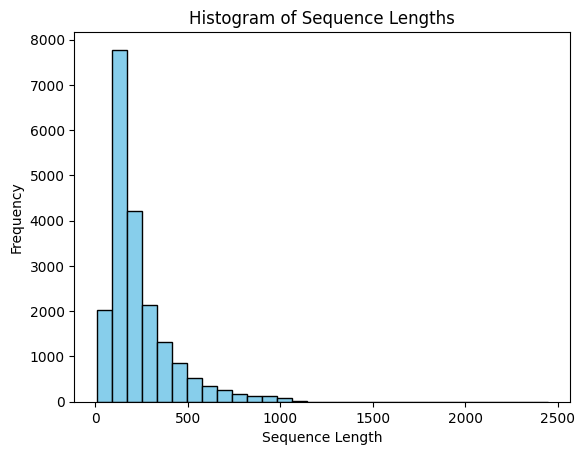

In [142]:
# Let's take a look at the sequences to get the max length for training
sequence_lengths = [len(seq) for seq in X_train_seq]

plt.hist(sequence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


In [143]:
# Pad sequences to a fixed length so they all match for the NN training
max_seq_length = 1100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Convert labels to one-hot encoded vectors
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

## Iterative results & discussion
Below I've kept track of the graphs over my iterations.  The graph on the left is my first submission which received a .89648 AUC score on Kaggle.  It didn't seem like from the graph the accuracies were converging just yet, so for my second attempt I decided to increase the number of epochs to get a better idea of when I should stop.  I increased it to 100 as you can see on the second graph.  It seems like 30 epochs is pretty good, which considering we're already using Adam (with an adaptive learning rate) that makes sense.  

For my third attempt I wanted to try a different architecture for my NN, so I added the bidirectional LSTM, this allows the model to incorporate information from both the past and future contexts.  However, reviewing the graph, the accuracy seemed unstable, which can happen with small or noisy datasets.  I tried adding a dropout layer next to stabilize it, and it did indeed improve.  I submitted this model to kaggle again, and my score improved by +.0026 (new score: .89908).

While waiting for that to train, I saw you can also apply recurrent dropout to LSTM layers which masks the recurrent connections between the memory calls.  It should help to ensure it isn't memorizing the training data.  This made the training SIGNIFICANTLY slower (the submission took 107 mins previous took approximately 23 mins).  Once the model finished, the results were underwhelming.  It's very unstable, and the accuracy isn't nearly as strong as the previous models.  As a final attempt, I switched the optimizer to SGD with a specific learning rate to compare with Adam and it performed terribly. The validation accuracy is surpassing the training accuracy, meaning it's generalizing better, but they're both still very low.  

<br>
<center> **Note that the y axes on the graphs aren't frozen** </center>
<br>


| First submission (Kaggle score: .89648) | Testing more epochs | Switched LSTM to Bidirectional LSTM |
| --| -- | -- |
| 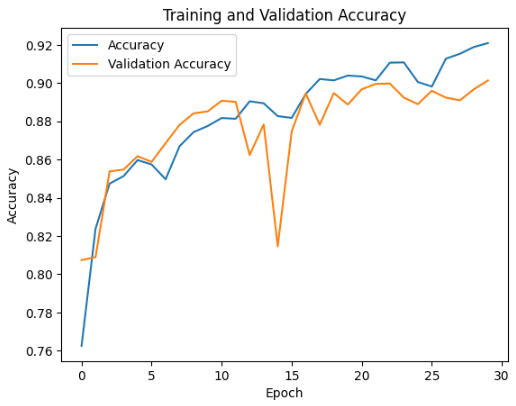 | 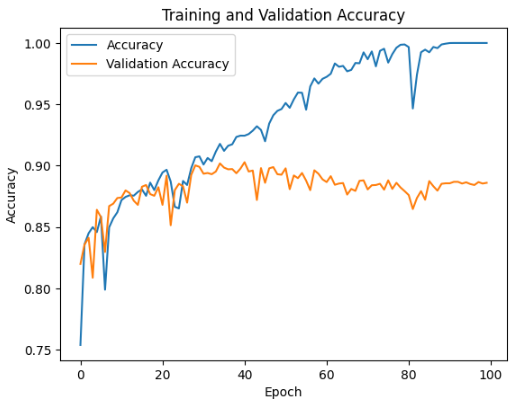| 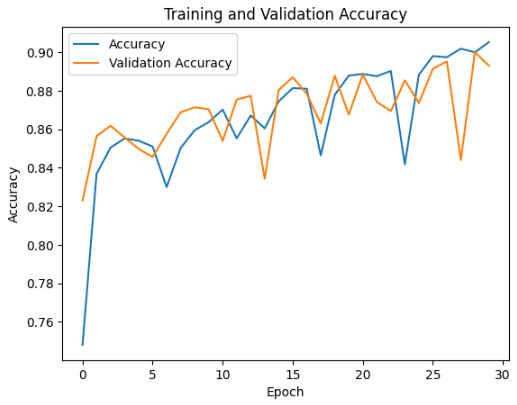 |


| Added dropout after Bidirectional LSTM (Kaggle score: 0.89908) | Switched to recurrent dropout (Kaggle score: .88324) | BLSTM, dropout, SGD, learning rate = .001 |
| -- | -- | -- |
| 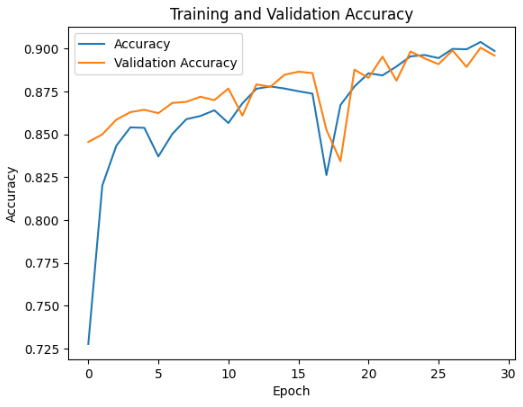 | 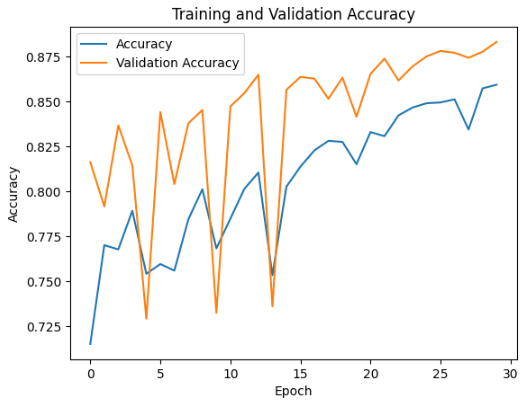 | 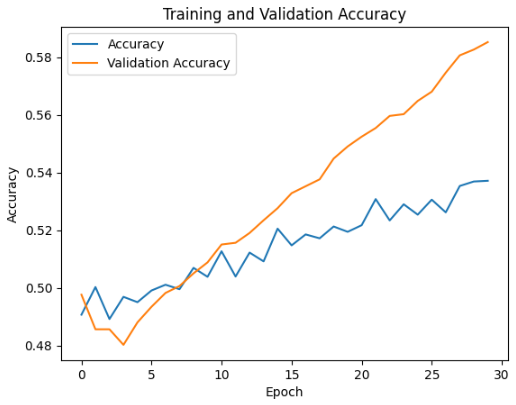 |

Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.6891 - loss: 0.5768 - val_accuracy: 0.8418 - val_loss: 0.3752
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.8257 - loss: 0.4085 - val_accuracy: 0.8388 - val_loss: 0.3839
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.8523 - loss: 0.3608 - val_accuracy: 0.8206 - val_loss: 0.4083
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.8380 - loss: 0.3831 - val_accuracy: 0.8638 - val_loss: 0.3294
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.8366 - loss: 0.3911 - val_accuracy: 0.8600 - val_loss: 0.3362
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.8555 - loss: 0.3606 - val_accuracy: 0.7476 - val_loss: 0.4988
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.8283 - loss: 0.4033 - val_accuracy: 0.8670 - val_loss: 0.3226
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.8560 - loss: 0

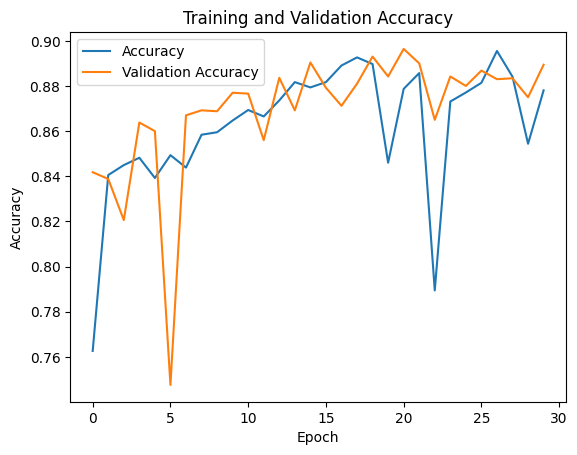

In [150]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Bidirectional, Dropout
from keras.callbacks import History
from tensorflow.keras.optimizers import SGD
history = History()

# Define custom Embedding layer to incorporate word2vec pre-trained weights
class PretrainedEmbedding(Layer):
    def __init__(self, weights, trainable=False, **kwargs):
        super(PretrainedEmbedding, self).__init__(**kwargs)
        self.embeddings = tf.Variable(weights, trainable=trainable)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.int32)  # Convert input indices to integer type
        return tf.nn.embedding_lookup(self.embeddings, inputs)

# Define model architecture
embedding_dim = model.vector_size
vocab_size = len(model.wv.key_to_index)
embedding_matrix = model.wv.vectors

# Add layers to NN_model
NN_model = Sequential()
NN_model.add(PretrainedEmbedding(weights=embedding_matrix, trainable=False))
# NN_model.add(LSTM(128))                                       # For attempt 3, switched to bidirectional
NN_model.add(Bidirectional(LSTM(128)))                        # For attempt 5, switched to LSTM w/reccurent dropout
NN_model.add(Dropout(.5))                                     # For attempt 4, added dropout
# NN_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))   # For attempt 6, switched to BLSTM w/dropout & SGD
NN_model.add(Dense(2, activation='softmax'))

# Compile, train, & evaluate model
NN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Switching to SGD for attempt 6
# learning_rate = 0.001
# optimizer = SGD(learning_rate=learning_rate)
# NN_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = NN_model.fit(X_train_pad, y_train_one_hot, validation_data=(X_test_pad, y_test_one_hot), epochs=30, batch_size=128, callbacks=[history])
loss, accuracy = NN_model.evaluate(X_test_pad, y_test_one_hot)

print("Test Accuracy:", accuracy)

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Conclusion
I think starting with the word2vec embeddings gave my model a huge head start.  After that, the changes I made were only slight enhancements.  I achieved some enhancement by adding the dropout layers & bidirectional LSTM layer, but the only change in the final attempt with the recurrent dropout was the significant increase in training time.  

In future versions, it would be interesting to try other word embedding methods such as GloVe (Global Vectors for Word Representation), FastText, or maybe BERT (Bidirectional Encoder Representations from Transformers) to see if there was any significant change in performance.  We could also try the CBOW algorithm in word2vec, or removing stop words as well.  Lastly, I think it would also be interesting to try training the model on a larger corpus of text then transferring it to this application. 

# Kaggle submission
> Below is the logic required for creating the submission.csv to submit results to kaggle

In [96]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


/tmp/ipykernel_34/620126829.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, "html.parser").get_text() # Remove the HTML / markdown tags e.g., </ br>


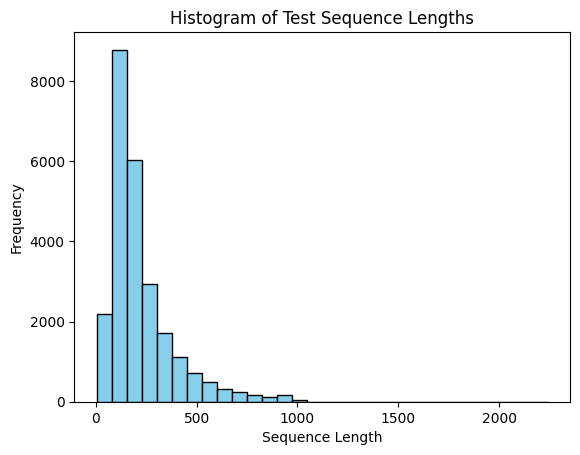

In [118]:
cleaned_reviews_test = reviews_to_clean_sentences(test['review'])

X_test_seq = [[model.wv.key_to_index[word] for word in sentence if word in model.wv.key_to_index] for sentence in cleaned_reviews_test]

# Let's take a look at the sequences to get the max length for training
test_sequence_lengths = [len(seq) for seq in X_test_seq]

# Plot histogram
plt.hist(test_sequence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Test Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [119]:
X_test_pad = pad_sequences(X_test_seq, maxlen=1100)

In [120]:
predictions = NN_model.predict(X_test_pad)

# Convert probabilities to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Extract the predicted sentiment (0 or 1) from binary_predictions
predicted_sentiments = binary_predictions[:, 1]  # Assuming the positive class is at index 1

# Create a DataFrame with IDs and predicted sentiments
submission_df = pd.DataFrame({'id': test['id'], 'sentiment': predicted_sentiments})

# Remove quotes from the IDs
submission_df['id'] = submission_df['id'].str.replace('"', '')

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step


## All kaggle submissions
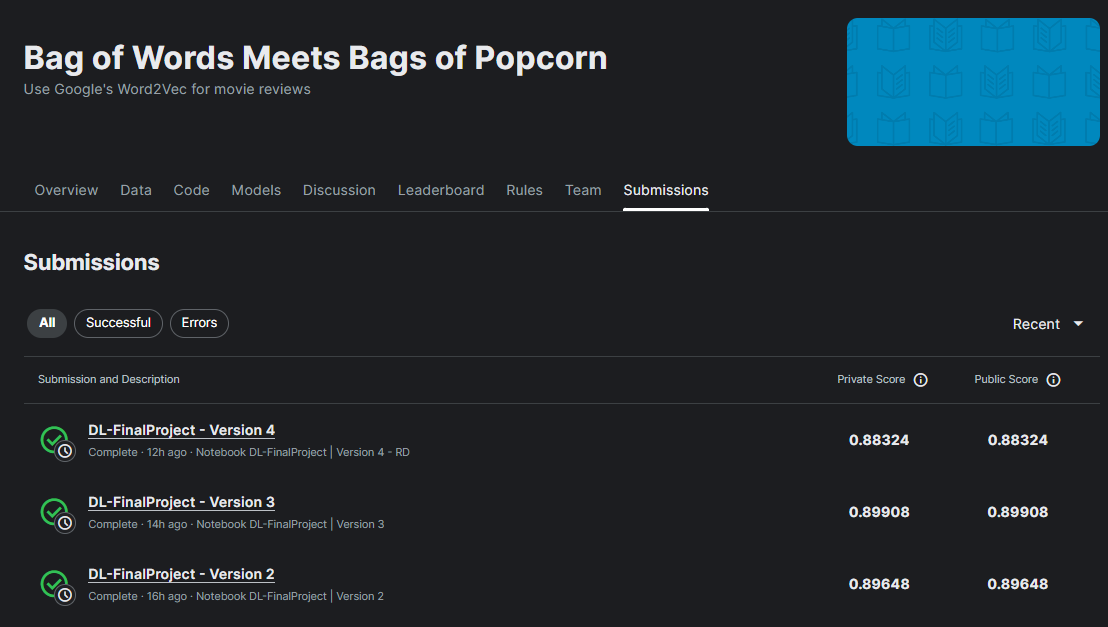

---
# References:

1. Kaggle Notebooks:
  1. [A Detailed Explanation of Keras Embedding Layer](https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer/notebook)
  2. [IMDB Review - Deep Model ~ 94.89% Accuracy](https://www.kaggle.com/code/nilanml/imdb-review-deep-model-94-89-accuracy)
  3. joycenv, Wendy Kan, Will Cukierski. (2014). [Bag of Words Meets Bags of Popcorn](https://kaggle.com/competitions/word2vec-nlp-tutorial) 
<br> <br>

2. Reference documentation:
  1. [TensorFlow - word2vec](https://www.tensorflow.org/text/tutorials/word2vec)
  2. [Google's trained Word2Vec model in Python](https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/)
<br> <br>

3. Research 
  1. T. Mikolov, K. Chen, G. Corrado, and J. Dean.  [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781).  Sept 2013.
  2. T. Mikolov, I. Sutskever, K. Chen, G. Corrado, and J. Dean. [Distributed Representations of Words and Phrases and their Compositionality](https://proceedings.neurips.cc/paper_files/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf). 2013
  3. T. Mikolov, Q.V. Le, and I. Sutskever.  [Exploiting Similarities among Languages for Machine Translation](https://arxiv.org/pdf/1309.4168v1) Sept. 2013
<br> <br>

4. Data sources
  1.  Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). "[Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf)." The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011). 